# Benchmark 2.0 

- This time, we are using a new database : SLKB, which has higher-quality, uniform data
- We are integrating the wilcox displacement estimate into the labeling of our positive results (which should have been done already)
- We will use no negative samples, instead relying on positive vs unlabeled samples
- Positive samples will be benchmarked against interactions found in n different cell lines
- SLKB uses different scoring systems with small overlap. 
  
- We will evaluate the overlap with each scoring system separately, at different thresholds : draw a heatmap table with one column per scoring system, and one row per score threshold, where each square is colored corresponding to the precision of the model.
- This heatmap can be redrawn for different p-value thresholds and numbers of cell lines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This excel file is the output of the model we want to benchmark

model_predictions = pd.read_excel("inputs/Supplementary_Table_11_CRISPR_DepMap_analysis.xlsx", sheet_name = None)

# We first extract the list of "mutant" genes included in our model, by getting the names of the tabs in the excel file, this will be used later
mutant_genes = model_predictions.keys()
mutant_genes_list = list(mutant_genes)

# Then, we extract a list of "ko" genes, which are simply all of the genes that each mutant (such as ARID1A) was tested against. 
# Of course, this also has to include ARID1A itself.
ko_genes_list = model_predictions['ARID1A']['gene'].tolist()
if 'ARID1A' not in ko_genes_list:
    ko_genes_list.append('ARID1A')

# Then, since the excel has multiple sheets, we concatenate them to obtain a single dataframe
model_predictions = pd.concat(
  [df for df in model_predictions.values()],
  ignore_index=True
)

model_predictions.head()

,mutant,gene,num_lines_high,num_lines_low,estimate,p_adj
0,ARID1A,EP300,98,98,-0.368858,8.644689e-08
1,ARID1A,MICOS10,98,98,-0.241643,7.014478e-07
2,ARID1A,PDCD10,98,98,-0.185685,2.418385e-06
3,ARID1A,SDHD,98,98,-0.236701,6.698955e-06
4,ARID1A,ROCK1,98,98,-0.115831,2.065706e-05


In [3]:
# This table, from SLKB, shows which SL pairs scored within the top 10% of 5 different scoring systems, among 22 different cell lines.
#
# Downloaded on 04/04/2025 from https://slkb.osubmi.org/, specifically here https://slkb.osubmi.org/session/00b5c112434073acd4ea9e9668422bec/download/download_data-predSL?w= 

slkb_predictions = pd.read_excel("inputs/SLKB_predictions.xlsx", sheet_name=None)

# Here, we also have to concatenate the different sheets
slkb_predictions = pd.concat(
  [df.assign(cell_line=name) for name, df in slkb_predictions.items()],
  ignore_index=True
)

# We separate the "gene_pair" column into two separate columns, to match the format of our first table
slkb_predictions[["gene1", "gene2"]] = slkb_predictions["gene_pair"].str.split('|', expand=True)
slkb_predictions.drop(columns="gene_pair", inplace=True)

# Finally, we filter it to only include the gene pairs where one of the studied genes is a "mutant" from our dataset, and the other is a ko gene
slkb_predictions = slkb_predictions[
    ((slkb_predictions["gene1"].isin(mutant_genes_list)) & slkb_predictions["gene2"].isin(ko_genes_list)) |
    ((slkb_predictions["gene2"].isin(mutant_genes_list)) & slkb_predictions["gene1"].isin(ko_genes_list))
]

slkb_predictions.head()

,GEMINI-Score,HORLBECK-Score,MAGECK-Score,MEDIAN-B/NB Score,sgRNA-Derived B/NB Score,total_count,cell_line,gene1,gene2
4,0,1,1,1,1,4,26864203_OVCAR8,CREBBP,ING5
5,0,1,1,1,1,4,26864203_OVCAR8,CREBBP,KDM1B
6,0,1,1,1,1,4,26864203_OVCAR8,CREBBP,KDM3B
21,0,1,1,1,0,3,26864203_OVCAR8,CREBBP,KDM2B
22,0,1,0,1,1,3,26864203_OVCAR8,CREBBP,KDM4A


In [4]:
scoring_systems_list = slkb_predictions.columns[0:5].to_list()

scoring_systems_list.append('consensus')

print(scoring_systems_list)

['GEMINI-Score', 'HORLBECK-Score', 'MAGECK-Score', 'MEDIAN-B/NB Score', 'sgRNA-Derived B/NB Score', 'consensus']


### Positive classification conditions for our model : 
- Wilcox displacement estimate over 0.15
- p-value under 1e-3 or 1e-4 (to be adjusted)
- for the gene pairs that were tested multiple times, one positive classification is sufficient

### SLKB conditions for positive classification
- It depends on the scoring system
- It depends on the number of cell lines in which it's been identified (2+)

In [ ]:
def get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines, total_count=None, print_tables=False):
    # Step 1: Get predicted SLIs
    hits_data = model_predictions[(model_predictions["estimate"] < -0.15) & (model_predictions["p_adj"] < p_adj_treshold)].copy()
    hits_data[["mutant", "gene"]] = hits_data[["mutant", "gene"]].apply(lambda row: sorted(row), axis=1, result_type="expand")
    hits_data = hits_data.rename(columns={"mutant": "gene1", "gene": "gene2"})
    predicted_pairs = set(map(tuple, hits_data[["gene1", "gene2"]].drop_duplicates().values))

    # Step 2: Get benchmark positives (known SLIs from scoring system)
    if scoring_system == "consensus":
        # Ensure total_count is provided
        if total_count is None:
            raise Exception("You must pass a minimum value for total_count to use the consensus scoring system")
        # Create a 'consensus' column
        slkb_predictions["consensus"] = (slkb_predictions["total_count"] >= total_count).astype(int)

    # Filter positive results based on the scoring system
    positive_results = slkb_predictions[slkb_predictions[scoring_system] == 1].copy()
    positive_results[["gene1", "gene2"]] = positive_results[["gene1", "gene2"]].apply(lambda row: sorted(row), axis=1, result_type="expand")
    positive_results_count = positive_results.groupby(["gene1", "gene2"]).sum().reset_index()
    known_pairs = set(map(tuple, positive_results_count[positive_results_count[scoring_system] >= num_cell_lines][["gene1", "gene2"]].values))

    # Step 3: Compute confusion matrix sets
    true_positives = predicted_pairs & known_pairs
    false_positives = predicted_pairs - known_pairs
    false_negatives = known_pairs - predicted_pairs

    # Optional: true negatives require knowing the universe of tested gene pairs
    all_pairs = set(map(tuple, slkb_predictions[["gene1", "gene2"]].apply(sorted, axis=1).drop_duplicates()))
    true_negatives = all_pairs - (true_positives | false_positives | false_negatives)

    if print_tables:
        print("True Positives (TP):", len(true_positives))
        print(true_positives)
        print("False Positives (FP):", len(false_positives))
        print(false_positives)
        print("False Negatives (FN):", len(false_negatives))
        print(false_negatives)
        print("True Negatives (TN):", len(true_negatives))
        print(true_negatives)

    return {
        "TP": true_positives,
        "FP": false_positives,
        "FN": false_negatives,
        "TN": true_negatives
    }


def get_recall(p_adj_treshold, scoring_system, num_cell_lines, total_count=None):
    confusion = get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines, total_count)
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    recall = TP / (TP + FN) if (TP + FN) > 0 else None
    return recall


def get_precision(p_adj_treshold, scoring_system, num_cell_lines, total_count=None):
    confusion = get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines, total_count)
    TP = len(confusion["TP"])
    FP = len(confusion["FP"])
    precision = TP / (TP + FP) if (TP + FP) > 0 else None
    return precision

def get_pu_metric

p_adj_treshold=0.0001
scoring_system="consensus"
total_count=1
num_cell_lines=4

precision = get_precision(p_adj_treshold, scoring_system, total_count, num_cell_lines)
recall = get_recall(p_adj_treshold, scoring_system, total_count, num_cell_lines)
print(precision, recall)

0.010752688172043012 0.043478260869565216


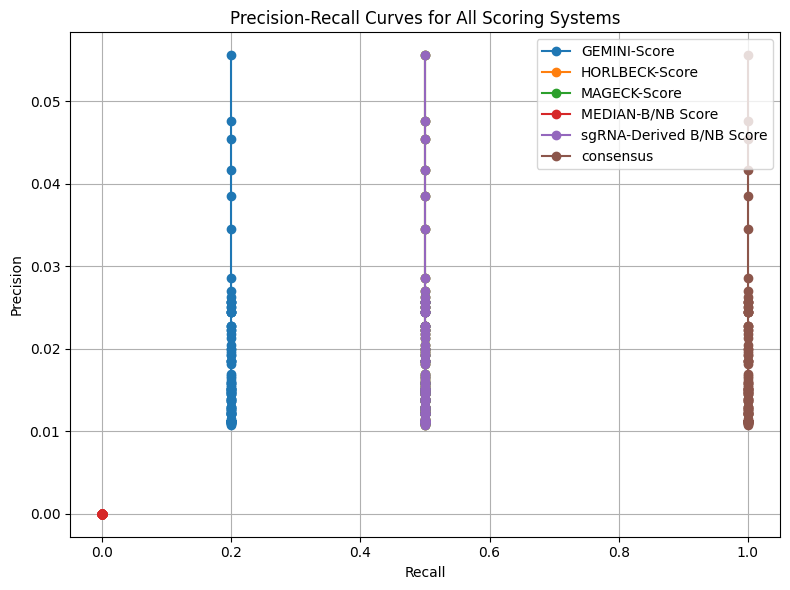

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the p-value thresholds
p_adj_thresholds = np.linspace(0, 0.0001, 100)

# Set number of required supporting cell lines for ground truth
num_cell_lines = 3
total_count = 3

plt.figure(figsize=(8, 6))

# Loop through each scoring system
for scoring_system in scoring_systems_list:
    precisions = []
    recalls = []

    for thresh in p_adj_thresholds:
        precision = get_precision(thresh, scoring_system, num_cell_lines, total_count)
        recall = get_recall(thresh, scoring_system, num_cell_lines, total_count)
        
        if precision is not None and recall is not None:
            precisions.append(precision)
            recalls.append(recall)

    plt.plot(recalls, precisions, marker='o', label=scoring_system)

# Final plot adjustments
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curves for All Scoring Systems")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Now, we want to generate a heatmap for different scoring systems and cell line numbers
def draw_precision_recall_table(p_adj_treshold, cell_line_numbers=[1, 2, 3, 4, 5], total_count=None):
    hit_rates_dict = {}
    hit_rates_dict["num_cell_lines"] = cell_line_numbers

    for scoring_system in scoring_systems_list:
        if scoring_system == "consensus" and total_count == None:
            continue
        # Create a column containing the precision for all cell line numbers
        column_name = scoring_system + "_Precision" if scoring_system != "consensus" else scoring_system + "_>=" + str(total_count) + "_Precision"
        hit_rates_dict[column_name] = []
        for num_cell_lines in cell_line_numbers:
            hit_rates_dict[column_name].append(get_precision(p_adj_treshold, scoring_system, num_cell_lines, total_count))

        # Create a column containing the recall for all cell line numbers
        column_name = scoring_system + "_Recall" if scoring_system != "consensus" else scoring_system + "_>=" + str(total_count) + "_Recall"
        hit_rates_dict[column_name] = []
        for num_cell_lines in cell_line_numbers:
            hit_rates_dict[column_name].append(get_recall(p_adj_treshold, scoring_system, num_cell_lines, total_count))

    hit_rates_df = pd.DataFrame(hit_rates_dict)
    return hit_rates_df

p_adj_treshold = 0.001
hit_rates_df = draw_precision_recall_table(p_adj_treshold, total_count=3)

hit_rates_df

,num_cell_lines,GEMINI-Score_Precision,GEMINI-Score_Recall,HORLBECK-Score_Precision,HORLBECK-Score_Recall,MAGECK-Score_Precision,MAGECK-Score_Recall,MEDIAN-B/NB Score_Precision,MEDIAN-B/NB Score_Recall,sgRNA-Derived B/NB Score_Precision,sgRNA-Derived B/NB Score_Recall,consensus_>=3_Precision,consensus_>=3_Recall
0,1,0.008696,0.016529,0.008696,0.011561,0.004348,0.008065,0.004348,0.008696,0.008696,0.01626,0.004348,0.016393
1,2,0.004348,0.052632,0.004348,0.052632,0.004348,0.111111,0.000000,0.000000,0.004348,0.06250,0.004348,0.333333
2,3,0.004348,0.200000,0.004348,0.500000,0.004348,0.500000,0.000000,0.000000,0.004348,0.50000,0.004348,1.000000
3,4,0.000000,0.000000,0.004348,1.000000,0.004348,1.000000,0.000000,NaN,0.004348,1.00000,0.000000,NaN
4,5,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN


In [ ]:
p_adj_treshold = 0.001
scoring_system = "consensus"
num_cell_lines = 3
test = get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines, total_count=3, print_tables=True)
precision = get_precision(p_adj_treshold, scoring_system, num_cell_lines, total_count=3)
recall = get_recall(p_adj_treshold, scoring_system, num_cell_lines, total_count=3)
print(f"precision: {precision}")
print(f"recall: {recall}")

True Positives (TP): 1
{('SMARCA2', 'SMARCA4')}
False Positives (FP): 229
{('PBRM1', 'UBA5'), ('EED', 'TAF1D'), ('COQ4', 'KMT2C'), ('ATP6V1G1', 'PBRM1'), ('BAP1', 'FAM50A'), ('PBRM1', 'SEC61A1'), ('ARID2', 'SDHD'), ('COX5B', 'SMARCA4'), ('ARID1A', 'MRPL36'), ('KLF5', 'PBRM1'), ('EFR3A', 'PBRM1'), ('ARID1B', 'SEPSECS'), ('MICOS10', 'SETD2'), ('ARID1B', 'TAF10'), ('ARID1A', 'ATP1B3'), ('KMT2C', 'UQCRC1'), ('ARID1A', 'MICOS10'), ('BAP1', 'CDS2'), ('COPS4', 'PBRM1'), ('PBRM1', 'VPS37A'), ('SEPHS2', 'SMARCA4'), ('ARHGEF7', 'PBRM1'), ('ARID2', 'COX5B'), ('SMARCA2', 'TRIM37'), ('CRKL', 'SMARCA2'), ('ARID1B', 'CDS2'), ('ARID2', 'RARS2'), ('LIMS1', 'PBRM1'), ('KMT2C', 'SDHD'), ('SDHD', 'SMARCA4'), ('FECH', 'SMARCA4'), ('SMARCA4', 'TTF2'), ('ARID2', 'TOMM22'), ('EED', 'WWTR1'), ('EP300', 'SETD2'), ('KMT2C', 'SUPT7L'), ('NAMPT', 'SMARCA4'), ('EP300', 'KMT2D'), ('ADSL', 'KMT2C'), ('BAP1', 'SEPHS2'), ('EP300', 'KMT2C'), ('PBRM1', 'UBA52'), ('KMT2C', 'MRPS21'), ('BAP1', 'HSPA8'), ('MARK2', 'PBRM1'),

It seems that the only gene pair on SLKB that was labeled in 4 or more cell lines by any score was SMARCA2/SMARCA4, which incidentally happens to be labeled by the model. Let's see what other pairs are on SLKB if we remove the filter for "mutant" genes : it may give us additional pairs to try

In [9]:
# With the same code from the beginning, we generate a 2nd table where we filter differently to keep all gene pairs that contain 2 "ko" genes instead of "mutants"

# This table, from SLKB, shows which SL pairs scored within the top 10% of 5 different scoring systems, among 22 different cell lines.
#
# Downloaded on 04/04/2025 from https://slkb.osubmi.org/, specifically here https://slkb.osubmi.org/session/00b5c112434073acd4ea9e9668422bec/download/download_data-predSL?w= 

slkb_predictions2 = pd.read_excel("inputs/SLKB_predictions.xlsx", sheet_name=None)

# Here, we also have to concatenate the different sheets
slkb_predictions2 = pd.concat(
  [df.assign(cell_line=name) for name, df in slkb_predictions2.items()],
  ignore_index=True
)

# We separate the "gene_pair" column into two separate columns, to match the format of our first table
slkb_predictions2[["gene1", "gene2"]] = slkb_predictions2["gene_pair"].str.split('|', expand=True)
slkb_predictions2.drop(columns="gene_pair", inplace=True)

# Finally, we filter it to only include the gene pairs where one of the studied genes is a "mutant" from our dataset, and the other is a ko gene
slkb_predictions2 = slkb_predictions2[
    ((slkb_predictions2["gene1"].isin(ko_genes_list)) & slkb_predictions2["gene2"].isin(ko_genes_list))
]

slkb_predictions2.head()

,GEMINI-Score,HORLBECK-Score,MAGECK-Score,MEDIAN-B/NB Score,sgRNA-Derived B/NB Score,total_count,cell_line,gene1,gene2
0,1,1,1,1,1,5,26864203_OVCAR8,KDM1B,MBD1
1,1,1,1,1,1,5,26864203_OVCAR8,KDM4A,KDM5A
2,1,1,1,1,1,5,26864203_OVCAR8,KDM4C,KDM5A
3,1,1,1,0,1,4,26864203_OVCAR8,BMI1,KDM1B
4,0,1,1,1,1,4,26864203_OVCAR8,CREBBP,ING5


In [10]:
def get_positives_list_enlarged(p_adj_treshold, scoring_system, num_cell_lines, print_tables=False):
    # Get the list of "hit pairs" at a given adjusted p-value threshold, where the estimate is under -0.15 (since the sign was inverted by the model)
    hits_data = model_predictions[(model_predictions["estimate"] < -0.15) & (model_predictions["p_adj"] < p_adj_treshold)].copy()

    # Normalize hits_data
    hits_data[["mutant", "gene"]] = hits_data[["mutant", "gene"]].apply(lambda row: sorted(row), axis=1, result_type="expand")
    hits_data = hits_data.rename(columns={"mutant": "gene1", "gene": "gene2"})
    hits_data_unique = hits_data[["gene1", "gene2"]].drop_duplicates()

    # Find positive results
    positive_results = slkb_predictions2[slkb_predictions2[scoring_system] == 1]

    # Normalize gene pairs
    positive_results_normalized = positive_results.copy()
    positive_results_normalized[["gene1", "gene2"]] = (
        positive_results_normalized[["gene1", "gene2"]]
        .apply(lambda row: sorted(row), axis=1, result_type="expand")
    )

    # Group by the normalized pairs and add the number of positive results
    positive_results_count = positive_results_normalized.groupby(["gene1", "gene2"]).sum().reset_index()

    # Filter to keep only the results that have been found in num_cell_lines cell lines
    positive_benchmark_df = positive_results_count[positive_results_count[scoring_system] >= num_cell_lines]

    # Convert both to sets of tuples
    predicted_pairs = set(map(tuple, hits_data_unique[["gene1", "gene2"]].values))
    known_pairs = set(map(tuple, positive_benchmark_df[["gene1", "gene2"]].values))
    true_positives = predicted_pairs & known_pairs

    if print_tables:
        print("true positives :  \n", true_positives, "\n\n known pairs:  \n", known_pairs, "\n\n predicted pairs:  \n", predicted_pairs) 

    return known_pairs, true_positives

It looks like out of 268 different pairs detected in at least 4 cell lines, only 4 or 5 are detectable by the algorithm (tested in a separate notebook).